In [1]:
import datetime
import flax
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import optax
import e3nn_jax as e3nn
import json
import pickle
import seaborn as sns
import pandas as pd

from glob import glob
from tqdm import trange
from flax import serialization
from matscipy.neighbours import neighbour_list
from typing import Callable, Optional, Union

# 1. Load in the processed data

In [2]:
with open("data/mp-query/train_paths.json", "r") as f:
    train_fpaths = json.load(f)
with open("data/mp-query/test_paths.json", "r") as f:
    test_fpaths = json.load(f)
with open("data/mp-query/test_division.json", "r") as f:
    divison_dict = json.load(f)
    test_seen_ids = jnp.array(divison_dict["seen_ids"], dtype=jnp.int32)
    test_unseen_ids = jnp.array(divison_dict["unseen_ids"], dtype=jnp.int32)

In [3]:
print(f"Tot number of entries: {len(train_fpaths) + len(test_fpaths)}")

Tot number of entries: 766


In [4]:
with open("data/mp-query/atomic_number_mapping.json", "r") as f:
    Z_TO_SPECIES_MAPPING = json.load(f)
Z_TO_SPECIES_MAPPING = {int(Z): int(i) 
                        for Z, i in Z_TO_SPECIES_MAPPING.items()}
TOTNUM_SPECIES = len(Z_TO_SPECIES_MAPPING.keys())
CUTOFF = 5.0

In [5]:
Z_TO_SPECIES_MAPPING

{13: 0, 11: 1, 3: 2, 27: 3, 30: 4, 29: 5, 26: 6, 14: 7, 8: 8, 16: 9, 7: 10}

In [6]:
TOTNUM_SPECIES

11

In [7]:
def compute_edges(positions, cell, cutoff):
    """Compute edges of the graph from positions and cell."""
    receivers, senders, senders_unit_shifts = neighbour_list(
        quantities="ijS",
        pbc=np.array([True, True, True]),
        cell=cell,
        positions=positions,
        cutoff=cutoff,
    )

    num_edges = senders.shape[0]
    assert senders.shape == (num_edges,)
    assert receivers.shape == (num_edges,)
    assert senders_unit_shifts.shape == (num_edges, 3)
    return senders, receivers, senders_unit_shifts


def create_graph(positions, atomic_numbers, cell, energy, 
                 cutoff=CUTOFF, 
                 totnum_species=TOTNUM_SPECIES, 
                 z_to_species_mapping=Z_TO_SPECIES_MAPPING):
    """Create a graph from positions, cell, and energy."""
    senders, receivers, senders_unit_shifts = compute_edges(positions, cell, cutoff)

    # In a jraph.GraphsTuple object, nodes, edges, and globals can be any
    # pytree. We will use dicts of arrays.
    # What matters is that the first axis of each array has length equal to
    # the number of nodes, edges, or graphs.
    num_nodes = positions.shape[0]
    num_edges = senders.shape[0]
    num_sites = atomic_numbers.shape[0]
    
    # Check if the list of atomic numbers has the same length as num_nodes
    assert num_sites == num_nodes
    
    # Create the template for onehot encoding of chemical species (i.e., element)
    onehot_template = np.eye(totnum_species, dtype=np.int32)
    # Convert the atomic numbers into the chemical specie ids
    species_ids = [z_to_species_mapping[z] for z in atomic_numbers]
    # Create the final onehot specie encoding
    species_encodings = onehot_template[species_ids]

    graph = jraph.GraphsTuple(
        # positions, specie_encodings, specie_ids are per-node features:
        nodes=dict(positions=positions, 
                   species_encodings=species_encodings, 
                   species_ids=np.array(species_ids)),
        # Unit shifts are per-edge features:
        edges=dict(shifts=senders_unit_shifts),
        # energy and cell are per-graph features:
        globals=dict(energies=np.array([energy]), cells=cell[None, :, :]),
        # The rest of the fields describe the connectivity and size of the graph.
        senders=senders,
        receivers=receivers,
        n_node=np.array([num_nodes]),
        n_edge=np.array([num_edges]),
    )
    return graph

In [8]:
def load_graph(fpath: str) -> jraph.GraphsTuple:
    """Load the jraph GraphTuple"""
    with open(fpath, "r") as f:
        xstal_graph_dat = json.load(f)
        
    xstal_graph = create_graph(
        positions=np.array(xstal_graph_dat["positions"]),
        atomic_numbers=np.array(xstal_graph_dat["atomic_numbers"]),
        cell=np.array(xstal_graph_dat["cell"]),
        energy=xstal_graph_dat["eform_per_atom"]
    )
    return xstal_graph

In [9]:
train_graphs = [load_graph(fpath) for fpath in train_fpaths]
test_graphs = [load_graph(fpath) for fpath in test_fpaths]

In [10]:
train_dataset = jraph.batch(train_graphs)
test_dataset = jraph.batch(test_graphs)
train_nodes, train_edges = train_dataset.n_node, train_dataset.n_edge
test_nodes, test_edges = test_dataset.n_node, test_dataset.n_edge

Text(0.5, 0, 'Num of edges')

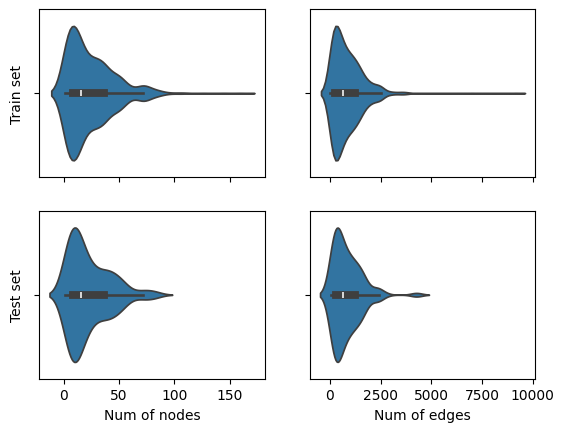

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex='col')
sns.violinplot(x=train_nodes, ax=axes[0,0])
sns.violinplot(x=test_nodes, ax=axes[1,0])
sns.violinplot(x=train_edges, ax=axes[0,1])
sns.violinplot(x=test_edges, ax=axes[1,1])
axes[0,0].set_ylabel("Train set")
axes[1,0].set_ylabel("Test set")
axes[1,0].set_xlabel("Num of nodes")
axes[1,1].set_xlabel("Num of edges")

# 2. Define a JAX implementation of the NEQUIPLayer

Taken from https://github.com/mariogeiger/nequip-jax/tree/main/nequip_jax

In [12]:
def default_radial_basis(r, n: int):
    """Default radial basis function."""
    return e3nn.bessel(r, n) * e3nn.poly_envelope(5, 2)(r)[:, None]


def simple_smooth_radial_basis(r, n: int):
    return e3nn.soft_one_hot_linspace(
        r,
        start=0.0,
        end=1.0,
        number=n,
        basis="smooth_finite",
        start_zero=False,
        end_zero=True,
    )


class NEQUIPLayerFlax(flax.linen.Module):
    avg_num_neighbors: float
    num_species: int = 1
    max_ell: int = 3
    output_irreps: e3nn.Irreps = 64 * e3nn.Irreps("0e + 1o + 2e")
    even_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.silu
    odd_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.tanh
    gate_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.silu
    mlp_activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.silu
    mlp_n_hidden: int = 64
    mlp_n_layers: int = 2
    radial_basis: Callable[[jnp.ndarray, int], jnp.ndarray] = default_radial_basis
    n_radial_basis: int = 8

    @flax.linen.compact
    def __call__(
        self,
        vectors: e3nn.IrrepsArray,
        node_feats: e3nn.IrrepsArray,
        node_specie: jnp.ndarray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
    ):
        return _impl(
            e3nn.flax.Linear,
            e3nn.flax.MultiLayerPerceptron,
            self,
            vectors,
            node_feats,
            node_specie,
            senders,
            receivers,
        )
    
def _impl(
    Linear: Callable,
    MultiLayerPerceptron: Callable,
    self: NEQUIPLayerFlax,
    vectors: e3nn.IrrepsArray,  # [n_edges, 3]
    node_feats: e3nn.IrrepsArray,  # [n_nodes, irreps]
    node_specie: jnp.ndarray,  # [n_nodes] int between 0 and num_species-1
    senders: jnp.ndarray,  # [n_edges]
    receivers: jnp.ndarray,  # [n_edges]
):
    node_feats = e3nn.as_irreps_array(node_feats)

    num_nodes = node_feats.shape[0]
    num_edges = vectors.shape[0]
    assert vectors.shape == (num_edges, 3)
    assert node_feats.shape == (num_nodes, node_feats.irreps.dim)
    assert node_specie.shape == (num_nodes,)
    assert senders.shape == (num_edges,)
    assert receivers.shape == (num_edges,)

    # we regroup the target irreps to make sure that gate activation
    # has the same irreps as the target
    output_irreps = e3nn.Irreps(self.output_irreps).regroup()

    messages = Linear(node_feats.irreps, name="linear_up")(node_feats)[senders]

    # Angular part
    messages = e3nn.concatenate(
        [
            messages.filter(output_irreps + "0e"),
            e3nn.tensor_product(
                messages,
                e3nn.spherical_harmonics(
                    [l for l in range(1, self.max_ell + 1)],
                    vectors,
                    normalize=True,
                    normalization="component",
                ),
                filter_ir_out=output_irreps + "0e",
            ),
        ]
    ).regroup()
    assert messages.shape == (num_edges, messages.irreps.dim)

    # Radial part
    with jax.ensure_compile_time_eval():
        assert abs(self.mlp_activation(0.0)) < 1e-6
    lengths = e3nn.norm(vectors).array
    mix = MultiLayerPerceptron(
        self.mlp_n_layers * (self.mlp_n_hidden,) + (messages.irreps.num_irreps,),
        self.mlp_activation,
        output_activation=False,
    )(self.radial_basis(lengths[:, 0], self.n_radial_basis))

    # Discard 0 length edges that come from graph padding
    mix = jnp.where(lengths == 0.0, 0.0, mix)
    assert mix.shape == (num_edges, messages.irreps.num_irreps)

    # Product of radial and angular part
    messages = messages * mix
    assert messages.shape == (num_edges, messages.irreps.dim)

    # Skip connection
    irreps = output_irreps.filter(keep=messages.irreps)
    num_nonscalar = irreps.filter(drop="0e + 0o").num_irreps
    irreps = irreps + e3nn.Irreps(f"{num_nonscalar}x0e").simplify()

    skip = Linear(
        irreps,
        num_indexed_weights=self.num_species,
        name="skip_tp",
        force_irreps_out=True,
    )(node_specie, node_feats)

    # Message passing
    node_feats = e3nn.scatter_sum(messages, dst=receivers, output_size=num_nodes)
    node_feats = node_feats / jnp.sqrt(self.avg_num_neighbors)

    node_feats = Linear(irreps, name="linear_down")(node_feats)

    node_feats = node_feats + skip
    assert node_feats.shape == (num_nodes, node_feats.irreps.dim)

    node_feats = e3nn.gate(
        node_feats,
        even_act=self.even_activation,
        odd_act=self.odd_activation,
        even_gate_act=self.gate_activation,
    )

    return node_feats

In [13]:
def get_relative_vectors(senders, receivers, n_edge, positions, cells, shifts):
    """Compute the relative vectors between the senders and receivers."""
    num_nodes = positions.shape[0]
    num_edges = senders.shape[0]
    num_graphs = n_edge.shape[0]

    assert positions.shape == (num_nodes, 3)
    assert cells.shape == (num_graphs, 3, 3)
    assert senders.shape == (num_edges,)
    assert receivers.shape == (num_edges,)
    assert shifts.shape == (num_edges, 3)

    # We need to repeat the cells for each edge.
    cells = jnp.repeat(cells, n_edge, axis=0, total_repeat_length=num_edges)

    # Compute the two ends of each edge.
    positions_receivers = positions[receivers]
    positions_senders = positions[senders] + jnp.einsum("ei,eij->ej", shifts, cells)

    vectors = e3nn.IrrepsArray("1o", positions_receivers - positions_senders)
    return vectors

In [14]:
class Model(flax.linen.Module):
    @flax.linen.compact
    def __call__(self, graphs):
        num_nodes = graphs.nodes["positions"].shape[0]
        senders = graphs.senders
        receivers = graphs.receivers
        # retrieve the onehot species encodings
        species_encodings = graphs.nodes["species_encodings"]
        # retrieve the specie ids
        species_ids = graphs.nodes["species_ids"]
        num_species = species_encodings.shape[1]

        vectors = get_relative_vectors(
            senders,
            receivers,
            graphs.n_edge,
            positions=graphs.nodes["positions"],
            cells=graphs.globals["cells"],
            shifts=graphs.edges["shifts"],
        )

        # We divide the relative vectors by the cutoff
        # because NEQUIPLayerFlax assumes a cutoff of 1.0
        vectors = vectors / CUTOFF

        # Embedding: since we have a single atom type, we don't need embedding
        # The node features are just ones and the species indices are all zeros
        # features = e3nn.IrrepsArray("0e", jnp.ones((num_nodes, 1)))
        # species = jnp.zeros((num_nodes,), dtype=jnp.int32)
        features = e3nn.IrrepsArray(f"{num_species:d}x0e", jnp.array(species_encodings))
        species = jnp.array(species_ids, dtype=jnp.int32)

        # Apply 3 Nequip layers with different internal representations
        for irreps in [
            "32x0e + 8x1o + 8x2e",
            "32x0e + 8x1o + 8x2e",
            "32x0e",
        ]:
            layer = NEQUIPLayerFlax(
                avg_num_neighbors=20.0,  # average number of neighbors to normalize by
                output_irreps=irreps,
            )
            features = layer(vectors, features, species, senders, receivers)

        # Self-Interaction layers
        features = e3nn.flax.Linear("16x0e")(features)
        features = e3nn.flax.Linear("0e")(features)

        # Global Pooling
        # Average the features (energy prediction) over the nodes of each graph
        return e3nn.scatter_sum(features, nel=graphs.n_node) / graphs.n_node[:, None]

In [15]:
def loss_fn(preds, targets):
    """MSE Loss Function"""
    assert preds.shape == targets.shape
    return jnp.mean(jnp.square(preds - targets))

In [16]:
random_key = jax.random.PRNGKey(0)  # change it to get different initializations

# Initialize the model
model = Model()
params = jax.jit(model.init)(random_key, train_dataset)

# Initialize the optimizer
opt = optax.adam(1e-2)
opt_state = opt.init(params)

In [17]:
@jax.jit
def train_step(opt_state, params, dataset):
    """Perform a single training step."""
    num_graphs = dataset.n_node.shape[0]

    # Compute the loss as a function of the parameters
    def fun(w):
        preds = model.apply(w, dataset).array.squeeze(1)
        targets = dataset.globals["energies"]

        assert preds.shape == (num_graphs,)
        assert targets.shape == (num_graphs,)
        return loss_fn(preds, targets)

    # And take its gradient
    loss, grad = jax.value_and_grad(fun)(params)

    # Update the parameters and the optimizer state
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)

    return opt_state, params, loss

In [18]:
@jax.jit
def test_step(params, dataset):
    """Perform a single training step."""
    num_graphs = dataset.n_node.shape[0]
    
    # Obtain the predictions
    preds = model.apply(params, dataset).array.squeeze(1)
    targets = dataset.globals["energies"]

    assert preds.shape == (num_graphs,)
    assert targets.shape == (num_graphs,)
    
    # compute relevant loss
    error = preds - targets
    squared_error = jnp.square(error)
    abs_error = jnp.abs(error)
    mse_loss = jnp.mean(squared_error)
    mae_loss = jnp.mean(abs_error)
    
    seen_mse_loss = jnp.mean(squared_error[test_seen_ids])
    seen_mae_loss = jnp.mean(abs_error[test_seen_ids])
    
    unseen_mse_loss = jnp.mean(squared_error[test_unseen_ids])
    unseen_mae_loss = jnp.mean(abs_error[test_unseen_ids])

    return preds, mse_loss, mae_loss, seen_mse_loss, seen_mae_loss, unseen_mse_loss, unseen_mae_loss

In [19]:
train_losses = []
test_mses = []
test_maes = []
test_seen_mses = []
test_seen_maes = []
test_unseen_mses = []
test_unseen_maes = []
with trange(5000) as pbar:
    for _ in pbar:
        opt_state, params, train_loss = train_step(opt_state, params, train_dataset)
        _, test_mse, test_mae, test_seen_mse, test_seen_mae, test_unseen_mse, test_unseen_mae = test_step(params, test_dataset)
        train_losses.append(train_loss)
        test_mses.append(test_mse)
        test_maes.append(test_mae)
        test_seen_mses.append(test_seen_mse)
        test_seen_maes.append(test_seen_mae)
        test_unseen_mses.append(test_unseen_mse)
        test_unseen_maes.append(test_unseen_mae)
        pbar.set_postfix(
            train_loss=train_loss, test_loss=test_mse
        )

100%|██████████| 5000/5000 [18:13<00:00,  4.57it/s, test_loss=0.89818525, train_loss=0.0003140653] 


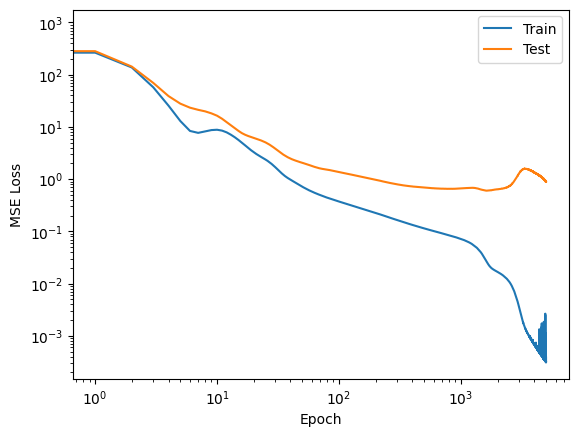

In [52]:
plt.plot(train_losses, label="Train")
plt.plot(test_mses, label="Test")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig("./figures/train-test-mse.pdf", dpi=300, bbox_inches="tight")

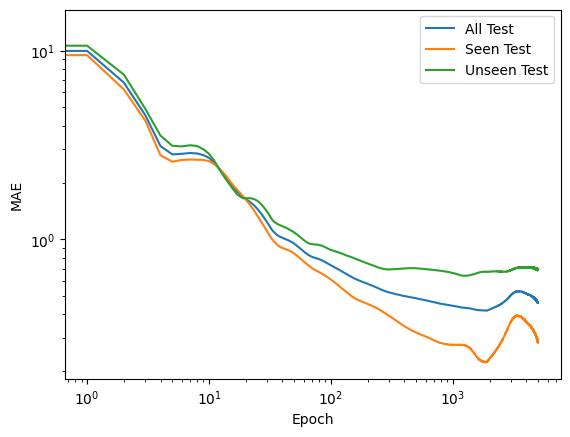

In [51]:
plt.plot(test_maes, label="All Test")
plt.plot(test_seen_maes, label="Seen Test")
plt.plot(test_unseen_maes, label="Unseen Test")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.savefig("./figures/test_losses.pdf", dpi=300, bbox_inches="tight")

In [50]:
test_maes[-1]

Array(0.46139318, dtype=float32)

In [22]:
testdata = test_graphs[0]
testdata.globals["energies"]

array([-1.90353159])

In [23]:
preds = model.apply(params, testdata).array.squeeze(1)

In [24]:
preds

Array([-0.8789989], dtype=float32)

In [25]:
error = test_step(params, test_dataset)[0] - test_dataset.globals["energies"]
print(jnp.mean(jnp.abs(error)))
print(jnp.mean(jnp.square(error)))

0.46139476
0.8981835


In [26]:
# get the error distribution of seen and unseen structures
seen_errors = error[test_seen_ids]
unseen_errors = error[test_unseen_ids]

Text(0.5, 0, 'Raw errors in formation energy per atom (eV/atom)')

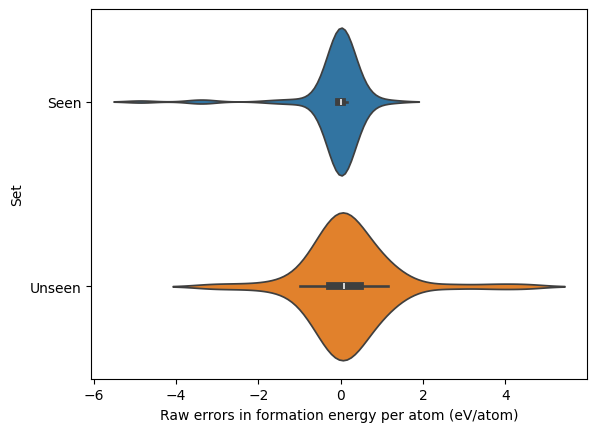

In [27]:
# plot the violin plot
test_plot_df = pd.DataFrame.from_dict(
    {
        "error": jnp.concatenate([seen_errors, unseen_errors]),
        "Set": ["Seen"] * seen_errors.shape[0] + ["Unseen"] * unseen_errors.shape[0]
    }
)
sns.violinplot(test_plot_df, x="error", y="Set", hue="Set")
plt.xlabel("Raw errors in formation energy per atom (eV/atom)")
# plt.xticks(range(-4, 6))
# plt.savefig("./figures/train-test-violin.pdf", dpi=300, bbox_inches="tight")

Text(0.5, 0, 'Absolute errors in formation energy per atom (eV/atom)')

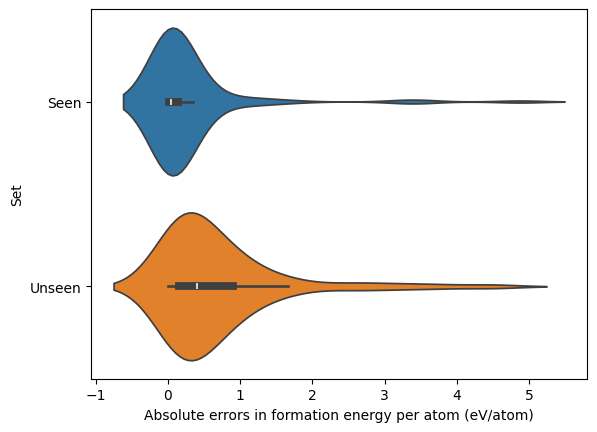

In [28]:
# plot the violin plot
test_plot_df = pd.DataFrame.from_dict(
    {
        "error": jnp.abs(jnp.concatenate([seen_errors, unseen_errors])),
        "Set": ["Seen"] * seen_errors.shape[0] + ["Unseen"] * unseen_errors.shape[0]
    }
)
sns.violinplot(test_plot_df, x="error", y="Set", hue="Set")
plt.xlabel("Absolute errors in formation energy per atom (eV/atom)")

Plot pred vs true for the training and prediction

In [29]:
train_preds, *_ = test_step(params, train_dataset)
train_trues = train_dataset.globals["energies"]

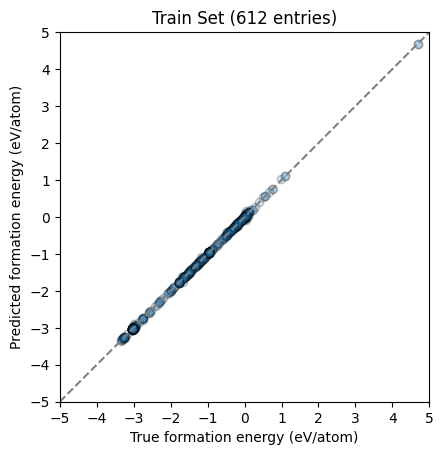

In [47]:
fig, ax = plt.subplots()
ax.scatter(
    x=train_trues,
    y=train_preds,
    edgecolor="k",
    alpha=0.2
)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xticks(range(-5, 6))
ax.set_yticks(range(-5, 6))
ax.set_xlabel("True formation energy (eV/atom)")
ax.set_ylabel("Predicted formation energy (eV/atom)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="gray", ls="dashed")
ax.set_title(f"Train Set ({train_trues.shape[0]} entries)")
ax.set_aspect("equal")
fig.savefig("./figures/train_pred_vs_true.pdf", dpi=300, bbox_inches="tight")

In [31]:
test_preds, *_ = test_step(params, test_dataset)

In [32]:
test_trues = test_dataset.globals["energies"]

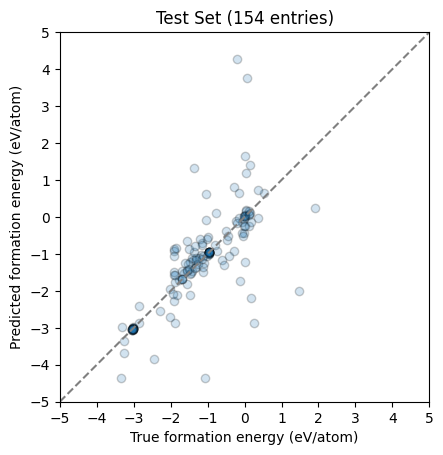

In [33]:
fig, ax = plt.subplots()
ax.scatter(
    x=test_trues,
    y=test_preds,
    edgecolor="k",
    alpha=0.2
)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xticks(range(-5, 6))
ax.set_yticks(range(-5, 6))
ax.set_xlabel("True formation energy (eV/atom)")
ax.set_ylabel("Predicted formation energy (eV/atom)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="gray", ls="dashed")
ax.set_title(f"Test Set ({test_trues.shape[0]} entries)")
ax.set_aspect("equal")

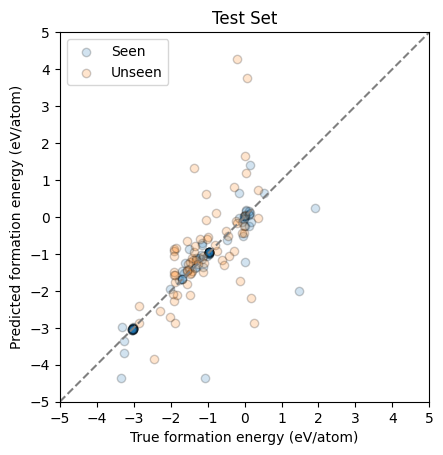

In [46]:
fig, ax = plt.subplots()
ax.scatter(
    x=test_trues[test_seen_ids],
    y=test_preds[test_seen_ids],
    edgecolor="k",
    label="Seen",
    alpha=0.2
)
ax.scatter(
    x=test_trues[test_unseen_ids],
    y=test_preds[test_unseen_ids],
    edgecolor="k",
    label="Unseen",
    alpha=0.2
)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xticks(range(-5, 6))
ax.set_yticks(range(-5, 6))
ax.set_xlabel("True formation energy (eV/atom)")
ax.set_ylabel("Predicted formation energy (eV/atom)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="gray", ls="dashed")
ax.set_title("Test Set")
ax.legend()
ax.set_aspect("equal")
fig.savefig("./figures/test_pred_vs_true.pdf", dpi=300, bbox_inches="tight")

# Save and load the trained model

In [35]:
model_params = serialization.to_state_dict(params)

In [36]:
with open("./data/models/v2.pkl", "wb") as f:
    pickle.dump(model_params, f)

In [37]:
with open("./data/models/v2.pkl", "rb") as f:
    loaded_params = pickle.load(f)

In [38]:
new_params = jax.jit(model.init)(random_key, train_dataset)

In [39]:
loaded_params = serialization.from_state_dict(new_params, loaded_params)

In [40]:
loaded_model = Model()

In [41]:
@jax.jit
def make_pred_with_loaded(params, dataset):
    return loaded_model.apply(params, dataset).array.squeeze(1)

In [42]:
train_preds = make_pred_with_loaded(loaded_params, train_dataset)

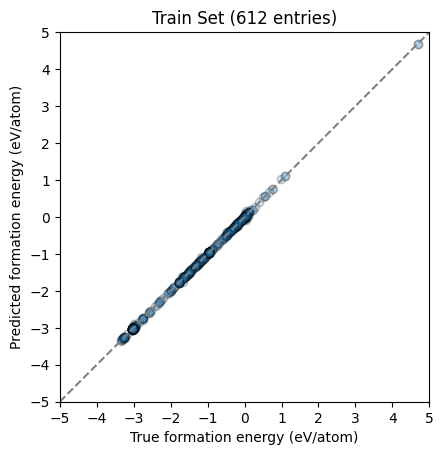

In [43]:
fig, ax = plt.subplots()
ax.scatter(
    x=train_trues,
    y=train_preds,
    edgecolor="k",
    alpha=0.2
)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xticks(range(-5, 6))
ax.set_yticks(range(-5, 6))
ax.set_xlabel("True formation energy (eV/atom)")
ax.set_ylabel("Predicted formation energy (eV/atom)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="gray", ls="dashed")
ax.set_title(f"Train Set ({train_trues.shape[0]} entries)")
ax.set_aspect("equal")